## UCI Machine Learning Repository : Adult Data Set

##### Goal : Predict whether income exceeds $50K/yr based on census data

In [2]:
# import for data-analysis
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

# import for calculations
from sklearn import metrics

# import for splitting data into training data and testing data
from sklearn.model_selection import train_test_split

# imports for machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# import to binarize output labels
from sklearn.preprocessing import label_binarize

# import for normalizing data
from sklearn.preprocessing import StandardScaler

# import to display tables
from IPython.display import display

# set seed to avoid result variations
np.random.seed(0)

# import data
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
                'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
train = pd.read_csv('adult_data.csv', sep=',\s', header=None, names=column_names, engine='python')
test = pd.read_csv('adult_test.csv', sep=',\s', header=None, names=column_names, engine='python')

# 'income' column in test data has periods at the end which need to be removed
test['income'].replace(regex=True, inplace=True, to_replace=r'\.', value=r'')

### 1.0 Data Analysis (Training + Test Data)

#### 1.1 Column Descriptions

In [3]:
# concatenate test and training data for overall statistics
adult = pd.concat([test,train])

# indexes get concatenated as well so reset them
adult.reset_index(inplace = True, drop = True)

# set type of categorical columns like 'workclass' as 'category'
for col in set(adult.columns) - set(adult.describe().columns):
    adult[col] = adult[col].astype('category')

print(adult.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         48842 non-null category
fnlwgt            48842 non-null int64
education         48842 non-null category
education-num     48842 non-null int64
marital-status    48842 non-null category
occupation        48842 non-null category
relationship      48842 non-null category
race              48842 non-null category
sex               48842 non-null category
capital-gain      48842 non-null int64
capital-loss      48842 non-null int64
hours-per-week    48842 non-null int64
native-country    48842 non-null category
income            48842 non-null category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None


#### 1.2 Column Statistics

In [4]:
adult.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### 2.0 Missing Values

In [5]:
for i,j in zip(adult.columns,(adult.values.astype(str) == '?').sum(axis = 0)):
    print(str(i) + ' : ' + str(j) + ' records')

age : 0 records
workclass : 2799 records
fnlwgt : 0 records
education : 0 records
education-num : 0 records
marital-status : 0 records
occupation : 2809 records
relationship : 0 records
race : 0 records
sex : 0 records
capital-gain : 0 records
capital-loss : 0 records
hours-per-week : 0 records
native-country : 857 records
income : 0 records


From the calculations above, it can be seen that three columns have missing values:

workclass : 2799<br/>
occupation : 2809<br/>
native-country : 857<br/>

#### 2.1 Missing value prediction

For each of the three columns with missing values,
we make predictions using logistic regression, decision trees, and random forests.
Predictions are based on the values of all columns other than the one under consideration.
If more than two predictors predict the same value, then it is considered as the final value.
If no predictors predict the same value, the majority value for that column is considered as the final value.

#### 2.2 Predicting missing 'workclass' values

In [6]:
# df stores all columns except the column with missing values which are to be predicted
# df_cols stores all categorical columns like 'income' (income is either <=50K or >50K)
# df_1 stores all the non-categorical columns like 'age'
# df_2 stores all categorical columns in 'one-hot-encoded' form
# columns like 'income' are converted to 'income_<=50K' and 'income_>50K' depending on their values
# column 'income_<=50K' gets set to 1 if column 'income' had value '<=50K' or 0 if 'income' had value '>50K'
def one_hot_enc_cat_cols(df, df_cols):
    df_1 = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])    
    return pd.concat([df_1, df_2], axis=1, join='inner')

# test_data stores all rows which have a missing value for 'workclass'
test_data = adult[(adult.workclass.values == '?')].copy()
# test_label stores 'workclass' for all rows where it is missing (all are ?)
test_label = test_data.workclass

# train_data stores all rows which have a value for 'workclass'
train_data = adult[(adult.workclass.values != '?')].copy()
# train_label stores 'workclass' for all rows where it is present
train_label = train_data.workclass

# drop the 'workclass' column from both training and test data
test_data.drop(columns = ['workclass'], inplace = True)
train_data.drop(columns = ['workclass'], inplace = True)

# call function to do one-hot-encoding of the categorical columns
train_data = one_hot_enc_cat_cols(train_data, train_data.select_dtypes('category').columns)
test_data = one_hot_enc_cat_cols(test_data, test_data.select_dtypes('category').columns)

# train logistic regression classifier and predict missing data
log_reg = LogisticRegression(max_iter=100, solver='saga')
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)

# train decision tree classifier and predict missing data
dt_clf = tree.DecisionTreeClassifier()
dt_clf = dt_clf.fit(train_data, train_label)
dt_clf_pred = dt_clf.predict(test_data)

# train random forest classifier and predict missing data
r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

# value_counts() gives the different values and their frequencies sorted in descending order
# majority_class holds the majority value for the column 'workclass'
majority_class = adult.workclass.value_counts().index[0]
# pred_df holds the predictions of all 3 classifiers for 'workclass' for all rows where it is missing
pred_df =  pd.DataFrame({'RanFor': r_forest_pred, 'DecTree' : dt_clf_pred, 'LogReg' : log_reg_pred})

# loop through the 'workclass' predictions of all 3 classifiers for every row of data where it was missing
# if more than one classifier predicts the same value, consider it as the final value
# otherwise predict the majority value as the final value
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

# fill the predicted values in the original data frame
adult.loc[(adult.workclass.values == '?'),'workclass'] = overall_pred.values

# confirm if there are no more missing values
print(adult.workclass.value_counts());
print(adult.workclass.unique());

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Private             36060
Self-emp-not-inc     3877
Local-gov            3143
State-gov            1982
Self-emp-inc         1696
Federal-gov          1432
Never-worked          631
Without-pay            21
?                       0
Name: workclass, dtype: int64
[Private, Local-gov, Never-worked, Self-emp-not-inc, Federal-gov, State-gov, Self-emp-inc, Without-pay]
Categories (8, object): [Private, Local-gov, Never-worked, Self-emp-not-inc, Federal-gov, State-gov, Self-emp-inc, Without-pay]


#### 2.3 Predicting missing 'occupation' values

In [7]:
test_data = adult[(adult.occupation.values == '?')].copy()
test_label = test_data.occupation

train_data = adult[(adult.occupation.values != '?')].copy()
train_label = train_data.occupation

test_data.drop(columns = ['occupation'], inplace = True)
train_data.drop(columns = ['occupation'], inplace = True)

train_data = one_hot_enc_cat_cols(train_data, train_data.select_dtypes('category').columns)
test_data = one_hot_enc_cat_cols(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression(max_iter=100, solver='saga')
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)

dt_clf = tree.DecisionTreeClassifier()
dt_clf = dt_clf.fit(train_data, train_label)
dt_clf_pred = dt_clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

majority_class = adult.occupation.value_counts().index[0]
pred_df =  pd.DataFrame({'RanFor': r_forest_pred, 'DecTree' : dt_clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)
adult.loc[(adult.occupation.values == '?'),'occupation'] = overall_pred.values

print(adult.occupation.value_counts());
print(adult.occupation.unique());

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Prof-specialty       7768
Craft-repair         6581
Exec-managerial      6138
Adm-clerical         5824
Sales                5601
Other-service        5123
Machine-op-inspct    3073
Transport-moving     2396
Handlers-cleaners    2103
Farming-fishing      1517
Tech-support         1466
Protective-serv       988
Priv-house-serv       249
Armed-Forces           15
?                       0
Name: occupation, dtype: int64
[Machine-op-inspct, Farming-fishing, Protective-serv, Adm-clerical, Other-service, ..., Sales, Priv-house-serv, Transport-moving, Handlers-cleaners, Armed-Forces]
Length: 14
Categories (14, object): [Machine-op-inspct, Farming-fishing, Protective-serv, Adm-clerical, ..., Priv-house-serv, Transport-moving, Handlers-cleaners, Armed-Forces]


#### 2.4 Predicting missing 'native-country' values

In [8]:
test_data = adult[(adult['native-country'].values == '?')].copy()
test_label = test_data['native-country']

train_data = adult[(adult['native-country'].values != '?')].copy()
train_label = train_data['native-country']

test_data.drop(columns = ['native-country'], inplace = True)
train_data.drop(columns = ['native-country'], inplace = True)

train_data = one_hot_enc_cat_cols(train_data, train_data.select_dtypes('category').columns)
test_data = one_hot_enc_cat_cols(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression(max_iter=100, solver='saga')
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)

dt_clf = tree.DecisionTreeClassifier()
dt_clf = dt_clf.fit(train_data, train_label)
dt_clf_pred = dt_clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

majority_class = adult['native-country'].value_counts().index[0]
pred_df =  pd.DataFrame({'RanFor': r_forest_pred, 'DecTree' : dt_clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)
adult.loc[(adult['native-country'].values == '?'),'native-country'] = overall_pred.values

print(adult['native-country'].value_counts());
print(adult['native-country'].unique());

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


United-States                 44640
Mexico                          961
Philippines                     305
Germany                         207
Puerto-Rico                     185
Canada                          182
El-Salvador                     155
India                           155
Cuba                            138
England                         127
China                           125
South                           121
Jamaica                         107
Italy                           105
Dominican-Republic              103
Japan                            95
Guatemala                        88
Vietnam                          88
Poland                           87
Columbia                         85
Haiti                            75
Portugal                         68
Taiwan                           67
Iran                             59
Greece                           49
Nicaragua                        49
Ecuador                          46
Peru                        

#### 2.5 Finding correlation between columns

In [9]:
# from the output above we can confirm that we no longer have missing values
# so remove them as a category
adult['workclass'] = adult['workclass'].cat.remove_categories('?')
adult['occupation'] = adult['occupation'].cat.remove_categories('?')
adult['native-country'] = adult['native-country'].cat.remove_categories('?')

display(adult.corr())

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519
education-num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689
capital-gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157
capital-loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467
hours-per-week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000


From the table above we can see that none of the columns are highly correlated

### 3.0 Additional Data Analysis

#### 3.1 Income distribution as a function of education level

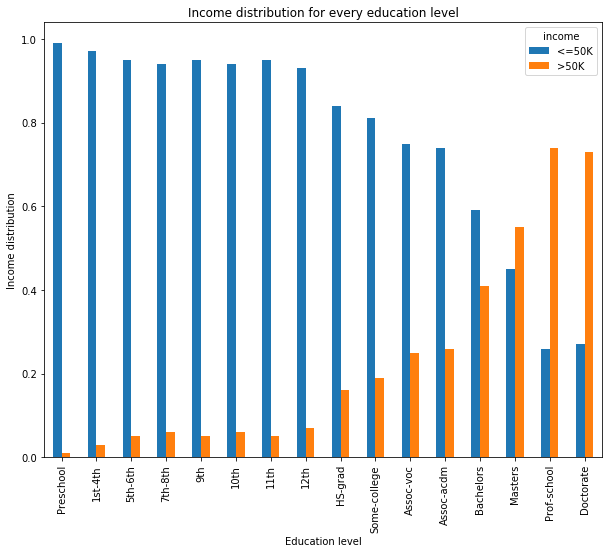

In [10]:
edu_level = {}
for x,y in adult[['education-num','education']].drop_duplicates().itertuples(index=False):
    edu_level[y] = x

education = round(pd.crosstab(adult.education, adult.income).div(pd.crosstab(adult.education, adult.income).apply(sum, axis=1), 0), 2)
education = education.reindex(sorted(edu_level, key=edu_level.get, reverse=False))

ax = education.plot(kind='bar', title='Income distribution for every education level', figsize=(10,8))
ax.set_xlabel('Education level')
ax.set_ylabel('Income distribution');

From the graph it can be seen that a higher proportion of people with higher education earn more than 50K.

#### 3.2 Income distribution as a function of gender

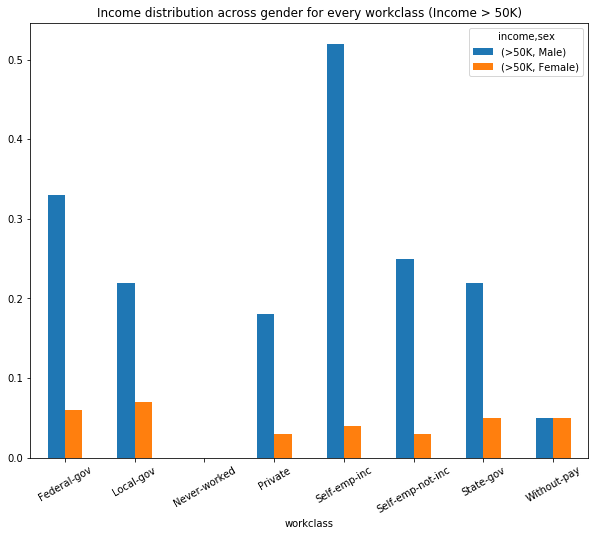

In [11]:
gender_workclass = round(pd.crosstab(adult.workclass, [adult.income, adult.sex]).div(pd.crosstab(adult.workclass, [adult.income, adult.sex]).apply(sum, axis=1), 0), 2)
gender_workclass[[('>50K','Male'), ('>50K','Female')]].plot(kind='bar', title='Income distribution across gender for every workclass (Income > 50K)', figsize=(10,8), rot=30)
ax.set_xlabel('Workclass')
ax.set_ylabel('Income distribution across gender (Income > 50K)');

From the graph it can be seen that there is a disparity in income across every work-class.

#### 3.3 Income distribution as a function of occupation

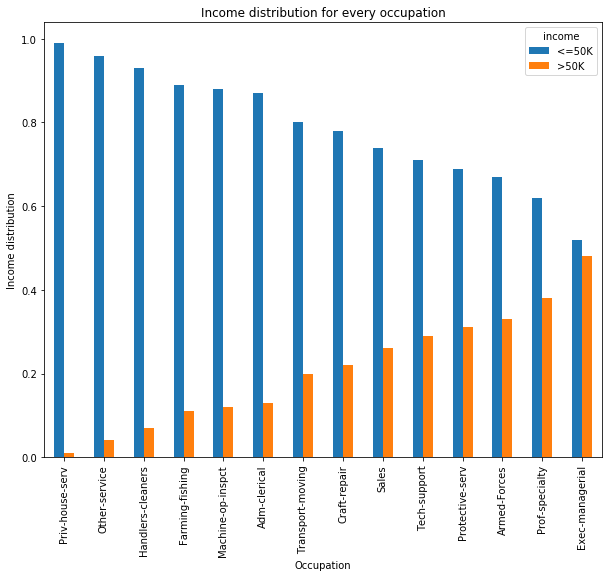

In [12]:
occupation = round(pd.crosstab(adult.occupation, adult.income).div(pd.crosstab(adult.occupation, adult.income).apply(sum, axis=1), 0), 2)
occupation.sort_values(by='>50K', inplace = True)
ax = occupation.plot(kind='bar', title='Income distribution for every occupation', figsize=(10,8))
ax.set_xlabel('Occupation')
ax.set_ylabel('Income distribution');

From the graph it can be seen that managerial and professional roles have a higher proportion of people who earn more than 50K.

#### 3.4 Income distribution as a function of workclass

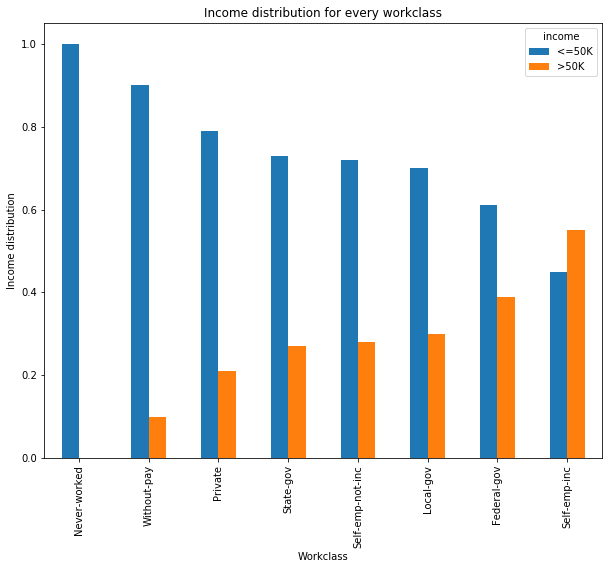

In [13]:
workclass = round(pd.crosstab(adult.workclass, adult.income).div(pd.crosstab(adult.workclass, adult.income).apply(sum, axis=1), 0), 2)
workclass.sort_values(by='>50K', inplace=True)
ax = workclass.plot(kind ='bar', title = 'Income distribution for every workclass', figsize=(10,8))
ax.set_xlabel('Workclass')
ax.set_ylabel('Income distribution');

From the graph it can be seen that more self-employed people earn more than 50K.

#### 3.5 Income distribution as a function of race

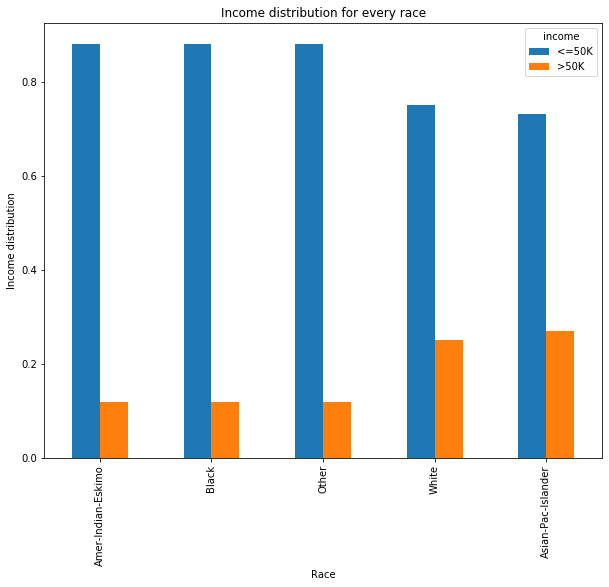

In [14]:
race = round(pd.crosstab(adult.race, adult.income).div(pd.crosstab(adult.race, adult.income).apply(sum, axis=1), 0), 2)
race.sort_values(by='>50K', inplace=True)
ax = race.plot(kind='bar', title='Income distribution for every race', figsize=(10,8))
ax.set_xlabel('Race')
ax.set_ylabel('Income distribution');

From the graph it can be seen that there is no significant variation in income among races.

#### 3.6 Income distribution as a function of work-hours

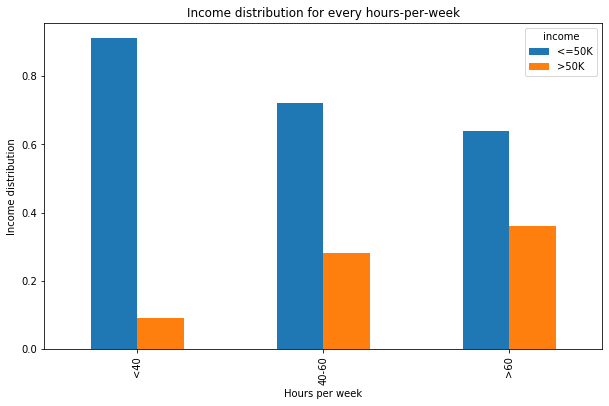

In [15]:
adult['hour_worked_bins'] = ['<40' if i < 40 else '40-60' if i <= 60 else '>60'  for i in adult['hours-per-week']]
adult['hour_worked_bins'] = adult['hour_worked_bins'].astype('category')
hours_per_week = round(pd.crosstab(adult.hour_worked_bins, adult.income).div(pd.crosstab(adult.hour_worked_bins, adult.income).apply(sum, axis=1), 0), 2)

hours_per_week.sort_values(by='>50K', inplace=True)
ax = hours_per_week.plot(kind='bar', title = 'Income distribution for every hours-per-week', figsize = (10,6))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Income distribution');

From the graph it can be seen that more people who work more than 60 hours per week earn more than 50K.

#### 3.7 Income distribution as a function of native country

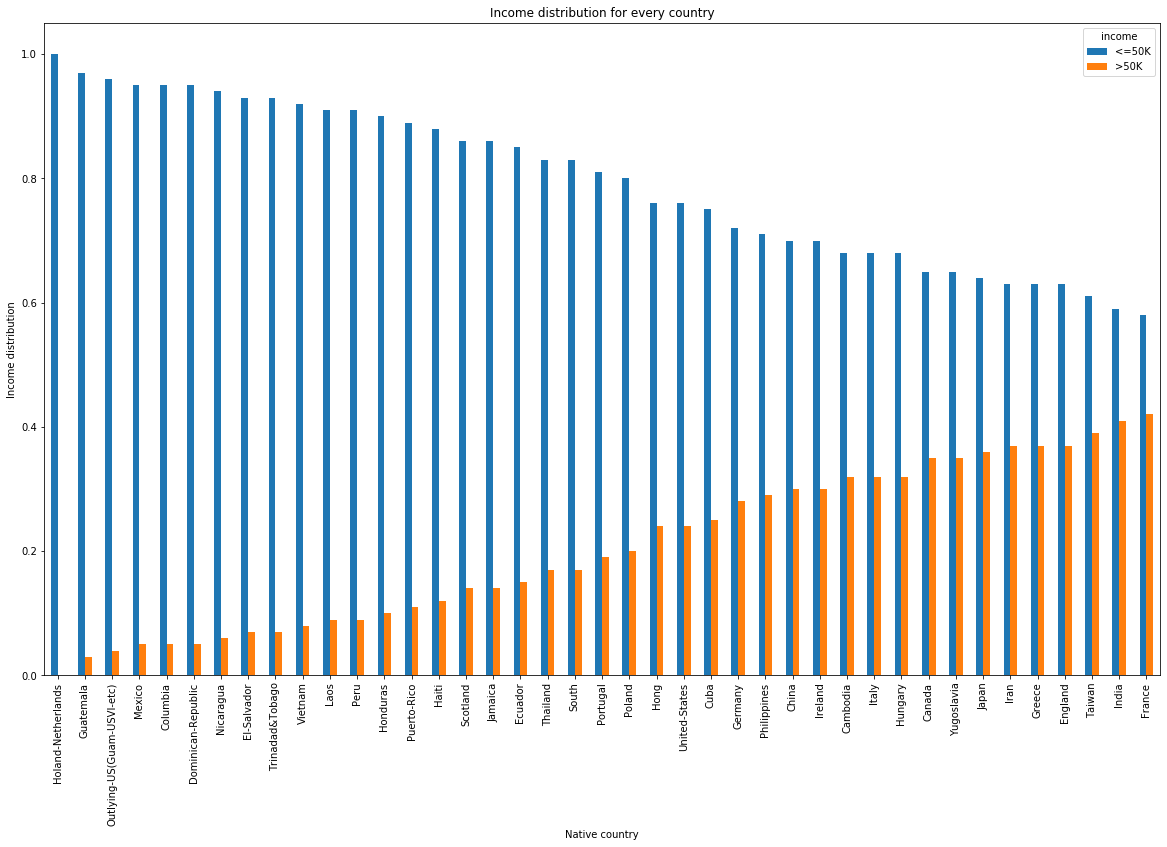

In [16]:
native_country = round(pd.crosstab(adult['native-country'], adult.income).div(pd.crosstab(adult['native-country'], adult.income).apply(sum, axis=1), 0), 2)
native_country.sort_values(by='>50K', inplace=True)
ax = native_country.plot(kind='bar', title='Income distribution for every country', figsize=(20,12))
ax.set_xlabel('Native country')
ax.set_ylabel('Income distribution');

From the graph it can be seen that a larger proportion of people from some countries earn more than 50K than people from other countries.

### 4.0 Data Transformation

#### 4.1 Feature selection

- The features 'education' and 'education-num' convey the same meaning. We consider only 'education-num'.<br/>
- We dropped the 'hours-per-week' feature and used hour_worked_bins (a categorical feature) in its place.
- We dropped the 'fnlwgt' feature as it does not seem to be related to the people being studied.

#### 4.2 Data preparation

We use one hot encoding for all the categorical columns.
Consider the 'hour_worked_bins' column.
It can have values like '<40', '40-60', and '>60'.
So we create columns 'hour_worked_bins_<40', 'hour_worked_bins_40-60', and 'hour_worked_bins_>60'
If any row of the column 'hour_worked_bins' had a value '<40',
then the column 'hour_worked_bins_<40' would be set to 1.0 or 0.0 otherwise.

In [17]:
adult_data = adult.drop(columns=['income'])
adult_label = adult.income

# one-hot-encode all categorical data
adult_cat_one_hot = pd.get_dummies(adult_data.select_dtypes('category'))
# all non-categorical data
adult_non_cat = adult_data.select_dtypes(exclude = 'category')
# all data
adult_data_one_hot = pd.concat([adult_non_cat, adult_cat_one_hot], axis=1, join='inner')

# split data into training and testing (75%, 25%) split
train_data, test_data, train_label, test_label = train_test_split(adult_data_one_hot, adult_label, test_size=0.25)

#### 4.3 Data normalization

We normalize the data by subtracting the mean from the data and scaling it to unit variance.

In [18]:
scaler = StandardScaler()
# compute the mean and standard deviation of the training data
scaler.fit(train_data)

# scale the training data
train_data = scaler.transform(train_data)
# apply the same scaling to the test data
test_data = scaler.transform(test_data)

### 5.0 Model Design

In [24]:
# function to evaluate models based on actual and predicted outputs
def evaluate_model(actual, predicted):    
    confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])
    true_positive = confusion.loc['>50K','>50K']
    true_negative = confusion.loc['<=50K','<=50K']
    false_positive = confusion.loc['<=50K','>50K']
    false_negative = confusion.loc['>50K','<=50K']

    accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    f_measure = (2 * recall * precision)/(recall + precision)
    sensitivity = true_positive/(true_positive + false_negative)
    specificity = true_negative/(true_negative + false_positive)
    error_rate = 1 - accuracy
    
    out = {'Error Rate':error_rate, 'Precision':precision, 'F-Measure':f_measure, 'Sensitivity':sensitivity, 'Specificity':specificity}    
    
    return out

In [49]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [50]:
np.cumsum(pca.explained_variance_ratio_)



array([0.04487599, 0.072677  , 0.09702508, 0.11945668, 0.14051839,
       0.15836492, 0.17538913, 0.19048482, 0.20488117, 0.21867771,
       0.2315413 , 0.24388459, 0.25561269, 0.26728226, 0.27876404,
       0.29002829, 0.30124727, 0.31221326, 0.32306949, 0.333746  ,
       0.34430127, 0.35481776, 0.36513969, 0.37534663, 0.38546528,
       0.39551414, 0.40554151, 0.41549387, 0.42537794, 0.43524975,
       0.44505408, 0.45483545, 0.46458389, 0.47430342, 0.48400181,
       0.49362882, 0.50323199, 0.51279827, 0.52231853, 0.53176662,
       0.54118642, 0.55055096, 0.55990735, 0.56924056, 0.57854753,
       0.58784321, 0.59713568, 0.60641692, 0.61569438, 0.62496907,
       0.63423978, 0.64350607, 0.65276713, 0.66202584, 0.67127691,
       0.68051923, 0.68975034, 0.69896518, 0.70816993, 0.71735147,
       0.72652431, 0.73567147, 0.74479814, 0.75391442, 0.76298887,
       0.77205879, 0.7811007 , 0.79013339, 0.79913072, 0.80808865,
       0.81702997, 0.82595684, 0.83480209, 0.8436108 , 0.85236

In [51]:
np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.9)



80

In [52]:
pca2 = PCA(n_components=81)
X_train_pca = pca2.fit_transform(train_data)
X_test_pca = pca2.transform(test_data)

#### 5.1 Decision Tree

- We used both Gini Index and Entropy to decide the splits of the decision tree.
- Minimum samples to split an internal node = 5%
- Minimum samples required at leaf node = 0.1%

In [71]:
# new
ms = []
errTr = []
errTe = []
DTree_Gini_best = dict
Min_err = 1
for i in range (2,100):
    clf_gini = tree.DecisionTreeClassifier(criterion='gini',  min_samples_split=32,  min_samples_leaf= i)
    clf_gini = clf_gini.fit(train_data, train_label)
    clf_gini_pred = clf_gini.predict(test_data)
    DTree_Gini = evaluate_model(test_label, clf_gini_pred)
    if(DTree_Gini_best is None ):
            DTree_Gini_best = DTree_Gini
            Min_err = round(DTree_Gini['Error Rate'],4)
    elif(Min_err > round(DTree_Gini['Error Rate'],4) ):
            DTree_Gini_best = DTree_Gini
            Min_err = round(DTree_Gini['Error Rate'],4)
        
    errTe.append(round(DTree_Gini['Error Rate'],4))
    ms.append(i)

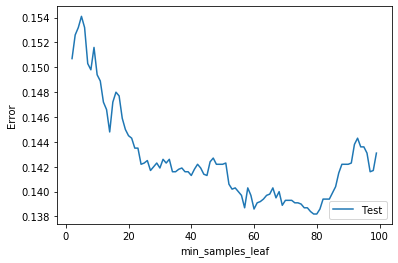

In [72]:
plt.plot(ms,errTe, label='Test')
plt.xlabel("min_samples_leaf")
plt.ylabel("Error")
plt.legend(loc='lower right')
plt.show()

In [73]:
bestMin_leaf_gini = np.argmin(errTe) + 2
print(np.min(errTe))
print(bestMin_leaf_gini)

0.1382
79


In [75]:
clf_gini = tree.DecisionTreeClassifier(criterion='gini',  min_samples_split=32,  min_samples_leaf= 79)
clf_gini = clf_gini.fit(train_data, train_label)
clf_gini_pred = clf_gini.predict(test_data)
   

In [81]:
# Entropy
ms = []
errTe = []
errTr = []
DTree_Entr_best = dict
Min_err = 1
clf_entropy_best = DecisionTreeClassifier
for i in range (2,200):
    clf_entropy = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=32, min_samples_leaf=i)
    clf_entropy = clf_entropy.fit(train_data, train_label)
    clf_entropy_pred = clf_entropy.predict(test_data)
    DTree_Entropy = evaluate_model(test_label, clf_entropy_pred)
    
    if(DTree_Entr_best is None ):
            DTree_Entropy_best = DTree_Entropy
            Min_err = round(DTree_Entropy['Error Rate'],4)
    elif(Min_err > round(DTree_Entropy['Error Rate'],4) ):
            DTree_Entropy_best = DTree_Entropy
            Min_err = round(DTree_Entropy['Error Rate'],4)
            
    clf_entropy_pred = clf_entropy.predict(train_data)
    DTree_EntropyTr = evaluate_model(train_label, clf_entropy_pred)     
    errTe.append(round(DTree_EntropyTr['Error Rate'],4))
    ms.append(i)



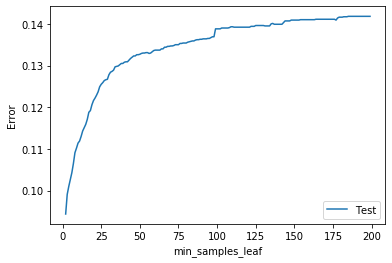

In [82]:
plt.plot(ms,errTe, label='Test')
plt.xlabel("min_samples_leaf")
plt.ylabel("Error")
plt.legend(loc='lower right')
plt.show()

In [83]:
clf_entropy = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=32, min_samples_leaf=np.argmin(errTe) + 2)
clf_entropy = clf_entropy.fit(train_data, train_label)
clf_entropy_pred = clf_entropy.predict(test_data)
   

In [85]:
min(errTe)

0.0944

In [86]:
overall_dtree = round(pd.DataFrame([DTree_Entropy_best, DTree_Gini_best], index=['Decision Tree - Entropy', 'Decision Tree - Gini Index']), 4)
display(overall_dtree)

,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Decision Tree - Entropy,0.1390,0.7406,0.6808,0.630,0.9321
Decision Tree - Gini Index,0.1382,0.7474,0.6796,0.623,0.9352


From the results above it can be seen that using the Gini Index gives slightly better accuracy than Entropy.



##### Decision tree with PCA

In [66]:
clf_entropy2 = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=bestMinPar, min_samples_leaf=9)
clf_entropy2 = clf_entropy2.fit(X_train_pca, train_label)
clf_entropy_pred2 = clf_entropy2.predict(X_test_pca)
DTree_Entropy2 = evaluate_model(test_label, clf_entropy_pred2)
overall_dtree2 = round(pd.DataFrame([DTree_Entropy2], index=['Decision Tree - PCA - Entropy']), 4)
display(overall_dtree2)
    

,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Decision Tree - PCA - Entropy,0.1638,0.6905,0.6127,0.5506,0.9241



#### 5.2 Artificial Neural Network

- We experimented with various activation functions for an artificial neural network.
- We used the 'adam' solver for weight optimization as it is suited better for large data-sets.
- We also varied the number of hidden nodes in layers 1 and 2 for different activation functions.

In [90]:
# Hyperbolic Tangent (Tanh) activation function
# 'warm_start' is set to true in order to reuse the solution of the previous call to 'fit' as initialization
ann_tanh = MLPClassifier(activation='tanh', solver='adam', alpha=1e-1, hidden_layer_sizes=(10, 2), warm_start=True)
ann_tanh.fit(train_data, train_label)                         
ann_tanh_pred = ann_tanh.predict(test_data)
ANN_TanH = evaluate_model(test_label, ann_tanh_pred)

# Rectified Linear Unit (ReLU) activation function
# 'adam' is a stochastic gradient based optimizer
# 'warm_start' is set to true in order to reuse the solution of the previous call to 'fit' as initialization
ann_relu = MLPClassifier(activation='relu', solver='adam', alpha=1e-1, hidden_layer_sizes=(5, 2), learning_rate='invscaling', warm_start=True)
ann_relu.fit(train_data, train_label)                         
ann_relu_pred = ann_relu.predict(test_data)
ANN_relu = evaluate_model(test_label, ann_relu_pred)

# Logistic Sigmoid activation function
# 'adam' is a stochastic gradient based optimizer
# 'warm_start' is set to true in order to reuse the solution of the previous call to 'fit' as initialization
ann_log = MLPClassifier(activation='logistic', solver='adam', alpha=1e-4, hidden_layer_sizes=(5, 2), learning_rate='invscaling', warm_start=True)
ann_log.fit(train_data, train_label)                         
ann_log_pred = ann_log.predict(test_data)
ANN_log = evaluate_model(test_label, ann_log_pred)

# Identity (Linear) activation function
# 'adam' is a stochastic gradient based optimizer
# 'warm_start' is set to true in order to reuse the solution of the previous call to 'fit' as initialization
ann_identity = MLPClassifier(activation='identity', solver='adam', alpha=1e-1, hidden_layer_sizes=(5, 2), warm_start=True)
ann_identity.fit(train_data, train_label)                         
ann_identity_pred = ann_identity.predict(test_data)
ANN_identity = evaluate_model(test_label, ann_identity_pred)

overall_ann = round(pd.DataFrame([ANN_TanH, ANN_relu, ANN_log, ANN_identity], index=['ANN - Tanh', 'ANN - ReLU', 'ANN - Logistic', 'ANN - Identity']), 4)
display(overall_ann)

,Error Rate,Precision,F-Measure,Sensitivity,Specificity
ANN - Tanh,0.1480,0.7122,0.6644,0.6227,0.9226
ANN - ReLU,0.1431,0.7335,0.6691,0.6150,0.9312
ANN - Logistic,0.1461,0.7155,0.6696,0.6293,0.9230
ANN - Identity,0.1452,0.7245,0.6669,0.6178,0.9277


#### 5.3 Support Vector Machine

- We experimented with various kernel functions for support vector machines

In [91]:
# Linear kernel function
svm_clf_linear = svm.SVC(kernel='linear')
svm_clf_linear.fit(train_data, train_label)
svm_clf_linear_pred = svm_clf_linear.predict(test_data)
SVM_linear = evaluate_model(test_label, svm_clf_linear_pred)

# Polynomial kernel function
svm_clf_poly = svm.SVC(kernel='poly')
svm_clf_poly.fit(train_data, train_label)
svm_clf_poly_pred = svm_clf_poly.predict(test_data)
SVM_poly = evaluate_model(test_label, svm_clf_poly_pred)

# Sigmoid kernel function
svm_clf_sigmoid = svm.SVC(kernel='sigmoid')
svm_clf_sigmoid.fit(train_data, train_label)
svm_clf_sigmoid_pred = svm_clf_sigmoid.predict(test_data)
SVM_sigmoid = evaluate_model(test_label, svm_clf_sigmoid_pred)

overall_svm = round(pd.DataFrame([SVM_linear, SVM_poly, SVM_sigmoid], index=['SVM - Linear', 'SVM - Polynomial', 'SVM - Sigmoid']), 4)
display(overall_svm)

,Error Rate,Precision,F-Measure,Sensitivity,Specificity
SVM - Linear,0.1485,0.7281,0.6511,0.5889,0.9323
SVM - Polynomial,0.1658,0.7082,0.5879,0.5026,0.9363
SVM - Sigmoid,0.1744,0.6393,0.6155,0.5935,0.8970


#### 5.4 Random Forest

- We used both Gini Index and Entropy to decide the splits of the decision trees in the Random Forest.
- We experimented with different number of decision trees in the Random Forest.
- Minimum samples to split an internal node = 5%
- Minimum samples required at leaf node = 0.1%

In [92]:
# Gini Index
r_forest_gini = RandomForestClassifier(n_estimators=150, criterion='gini', max_features=None,  min_samples_split=2, min_samples_leaf=1)
r_forest_gini.fit(train_data, train_label)
r_forest_gini_pred = r_forest_gini.predict(test_data)
rforest_gini = evaluate_model(test_label, r_forest_gini_pred)

# Entropy
r_forest_entropy = RandomForestClassifier(n_estimators=150, criterion='entropy', max_features=None,  min_samples_split=2, min_samples_leaf=1)
r_forest_entropy.fit(train_data, train_label)
r_forest_entropy_pred = r_forest_entropy.predict(test_data)
rforest_entropy = evaluate_model(test_label, r_forest_entropy_pred)

overall_rf = round(pd.DataFrame([rforest_gini, rforest_entropy], index=['Random Forest - Gini Index','Random Forest - Entropy']), 4)
display(overall_rf)

,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Random Forest - Gini Index,0.1441,0.7183,0.6758,0.6380,0.9230
Random Forest - Entropy,0.1404,0.7304,0.6819,0.6394,0.9274


#### 5.5 Adaboost

- We found out that the best results were obtained by using a decision tree classifier
as the base estimator to build the boosted ensemble.

In [34]:
#new
depth = []
errTr = []
errTe = []
for i in range (1,10):
    print('depth=',i)
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i), n_estimators=100)                     
    ada.fit(train_data, train_label)
    ada_pred = ada.predict(test_data)
    adaboost_test = evaluate_model(test_label, ada_pred)
    overall_ada = round(pd.DataFrame([adaboost_test], index=['Adaboost_test']), 4)
    display(overall_ada)
    errTe.append(round(adaboost_test['Error Rate'],4))
    
    ada_pred_tr = ada.predict(train_data)
    adaboost_tr = evaluate_model(train_label, ada_pred_tr)
    overall_ada_tr = round(pd.DataFrame([adaboost_tr], index=['Adaboost_training']), 4)
    display(overall_ada_tr)
    errTr.append(round(adaboost_tr['Error Rate'],4))
    depth.append(i)



depth= 1


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.13,0.7648,0.7006,0.6464,0.9389


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_training,0.135,0.7702,0.6903,0.6255,0.9409


depth= 2


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1267,0.7576,0.716,0.6787,0.9332


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_training,0.125,0.7777,0.7214,0.6727,0.9391


depth= 3


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1339,0.7399,0.7002,0.6645,0.9281


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_training,0.1163,0.7996,0.7405,0.6896,0.9452


depth= 4


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.14,0.7196,0.6906,0.6638,0.9204


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_training,0.1027,0.816,0.7761,0.7398,0.9472


depth= 5


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1467,0.6996,0.6792,0.6599,0.9128


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_training,0.0848,0.8479,0.8174,0.789,0.9552


depth= 6


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.157,0.6729,0.6599,0.6474,0.9032


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_training,0.0544,0.8981,0.8853,0.8729,0.9686


depth= 7


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1625,0.6617,0.6471,0.6331,0.9004


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_training,0.0259,0.9511,0.9459,0.9407,0.9847


depth= 8


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1695,0.6486,0.6286,0.6098,0.8984


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_training,0.0008,0.9984,0.9984,0.9983,0.9995


depth= 9


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1691,0.6502,0.6288,0.6088,0.8992


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_training,0.0001,0.9999,0.9998,0.9997,1.0


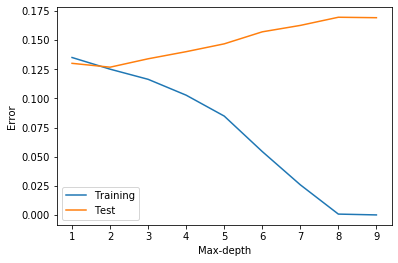

In [35]:
import matplotlib.pyplot as plt

plt.plot(depth,errTr,label='Training')
plt.plot(depth,errTe, label='Test')
plt.xlabel("Max-depth")
plt.ylabel("Error")
plt.legend(loc='lower left')
plt.show()



In [39]:
np.argmin(errTe)
depth[1]

[0.13, 0.1267, 0.1339, 0.14, 0.1467, 0.157, 0.1625, 0.1695, 0.1691]

In [54]:
bestdepth = 2
ms = []
errTr = []
errTe = []
for i in range (2,15):
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=bestdepth, min_samples_split = 2**i), n_estimators=100)                     
    print('min_samples_split=',2**i)
    ada.fit(train_data, train_label)
    ada_pred = ada.predict(test_data)
    adaboost_test = evaluate_model(test_label, ada_pred)
    overall_ada = round(pd.DataFrame([adaboost_test], index=['Adaboost_test']), 4)
    display(overall_ada)
    errTe.append(round(adaboost_test['Error Rate'],4))
    
    ada_pred_tr = ada.predict(train_data)
    adaboost_tr = evaluate_model(train_label, ada_pred_tr)
    overall_ada_tr = round(pd.DataFrame([adaboost_tr], index=['Adaboost_training']), 4)
    #display(overall_ada_tr)
    errTr.append(round(adaboost_tr['Error Rate'],4))
    ms.append(i)



min_samples_split= 4


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1268,0.7573,0.7159,0.6787,0.9331


min_samples_split= 8


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1267,0.7576,0.716,0.6787,0.9332


min_samples_split= 16


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1267,0.7576,0.716,0.6787,0.9332


min_samples_split= 32


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1266,0.7585,0.7158,0.6777,0.9336


min_samples_split= 64


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1249,0.7705,0.7158,0.6683,0.9387


min_samples_split= 128


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1258,0.7641,0.7158,0.6732,0.9361


min_samples_split= 256


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.126,0.7637,0.7154,0.6728,0.936


min_samples_split= 512


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1246,0.767,0.7186,0.6759,0.9368


min_samples_split= 1024


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1275,0.7617,0.711,0.6666,0.9359


min_samples_split= 2048


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1262,0.7703,0.7113,0.6606,0.9394


min_samples_split= 4096


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1251,0.7686,0.7161,0.6704,0.9379


min_samples_split= 8192


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1263,0.7676,0.7123,0.6645,0.9381


min_samples_split= 16384


,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost_test,0.1271,0.7507,0.7182,0.6885,0.9296


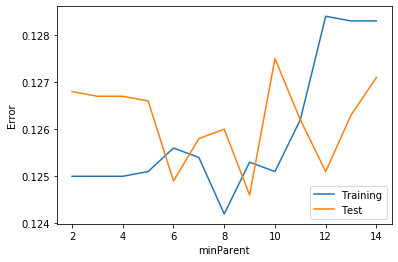

In [55]:
ms = []
for i in range(2,15):
    ms.append(i)
plt.plot(ms,errTr,label='Training')
plt.plot(ms,errTe, label='Test')
plt.xlabel("minParent")
plt.ylabel("Error")
plt.legend(loc='lower right')
plt.show()


In [56]:
bestMinPar = 2 ** (np.argmin(errTe) + 2)
bestMinPar

512

In [46]:
ms

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [68]:

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=bestdepth,min_samples_split = bestMinPar ), n_estimators=100)                     
ada.fit(train_data, train_label)
ada_pred = ada.predict(test_data)
adaboost = evaluate_model(test_label, ada_pred)
overall_ada = round(pd.DataFrame([adaboost], index=['Adaboost']), 4)
display(overall_ada)

,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost,0.1246,0.767,0.7186,0.6759,0.9368


##### Adaboost with PCA:

In [67]:
ada_pca = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,min_samples_split = bestMinPar ), n_estimators=100)                     
ada_pca.fit(X_train_pca, train_label)
ada_pca_pred = ada_pca.predict(X_test_pca)
adaboost_PCA = evaluate_model(test_label, ada_pca_pred)
overall_ada_pca = round(pd.DataFrame([adaboost_PCA], index=['Adaboost-PCA']), 4)
display(overall_ada_pca)

,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Adaboost-PCA,0.1583,0.6842,0.6437,0.6077,0.9137


It can be seen that Adaboost has the best accuracy thus far.

#### 5.6 Logistic Regression


In [95]:
# 'penalty' is the regularization penalty
# 'tol' is the tolerance for stopping criteria
# 'fit-intercept' specifies if a constant should be added to the decision function
log_reg = LogisticRegression(penalty='l2', dual=False, tol=1e-4, fit_intercept=True, solver='liblinear')
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)
logistic_reg = evaluate_model(test_label, log_reg_pred)

overall_logreg = round(pd.DataFrame([logistic_reg], index=['Logistic Regression']), 4)
display(overall_logreg)

,Error Rate,Precision,F-Measure,Sensitivity,Specificity
Logistic Regression,0.1455,0.7242,0.6658,0.6161,0.9278


#### 5.7 K Nearest Neighbors

- We evaluated the performance of K Nearest Neighbor classifiers for different values of K
ranging from 1 to 30 in steps of 2.

In [31]:
#new
knn_outs = []
knn_outstr = []
errTe= []
errTr = []
for i in range(1,50,3):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_data, train_label) 
    knn_pred = knn.predict(test_data)
    knn_perf = evaluate_model(test_label, knn_pred)
    knn_perf['k'] = i
    knn_outs.append(knn_perf)
    errTe.append(round(knn_perf['Error Rate'],4))
    knn_pred = knn.predict(train_data)
    knn_perf = evaluate_model(train_label, knn_pred)
    errTr.append(round(knn_perf['Error Rate'],4))
    knn_outstr.append(knn_perf)
#overall_knn = round(pd.DataFrame(knn_outs), 4)
#display(overall_knn)

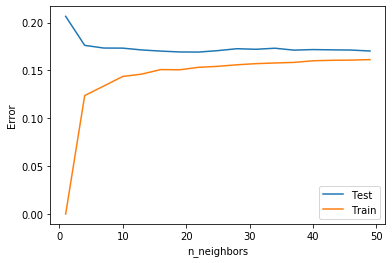

In [32]:
ms = []
for i in range(1,50,3):
    ms.append(i)
plt.plot(ms,errTe, label='Test')
plt.plot(ms,errTr, label='Train')
plt.xlabel("n_neighbors")
plt.ylabel("Error")
plt.legend(loc='lower right')
plt.show()

In [33]:
overall_knn = round(pd.DataFrame(knn_outs), 4)

display(pd.DataFrame(overall_knn))

,Error Rate,Precision,F-Measure,Sensitivity,Specificity,k
0,0.2065,0.5601,0.5654,0.5708,0.8621,1
1,0.1762,0.6818,0.5568,0.4706,0.9324,4
2,0.1734,0.6437,0.6153,0.5893,0.8997,7
3,0.1733,0.6712,0.5838,0.5165,0.9221,10
4,0.1714,0.6520,0.6152,0.5823,0.9044,13
5,0.1702,0.6723,0.5988,0.5399,0.9190,16
6,0.1693,0.6588,0.6180,0.5820,0.9073,19
7,0.1692,0.6731,0.6030,0.5461,0.9184,22
8,0.1707,0.6575,0.6121,0.5726,0.9082,25
9,0.1727,0.6620,0.5968,0.5433,0.9146,28


### 6.0 Model Comparison

#### 6.1 Statistics for all models developed

In [94]:
overall_eval = pd.concat([overall_dtree, overall_ann, overall_svm, overall_rf, overall_ada, overall_logreg], axis=0)
overall_eval.sort_values(by = ['F-Measure', 'Accuracy'], ascending=False, inplace=True)
display(overall_eval)

NameError: name 'overall_logreg' is not defined

From the table above we can see that the Adaboost model has the highest accuracy and F-measure values.
It is followed by the artificial neural networks with various activation functions.

#### 6.2 ROC Curves

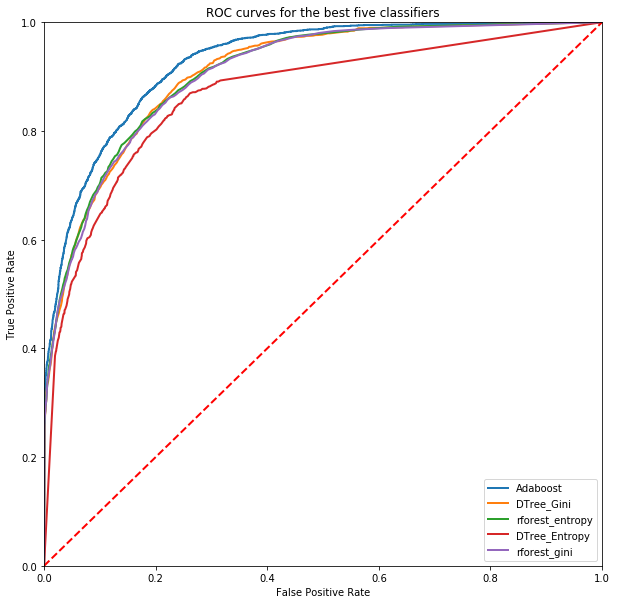

In [93]:
# function to plot ROC curves of input classifiers
def generate_roc(test_data, test_label, classifiers, pred_labels, plot_labels, plot_colors):
    
    # encode class '<=50K' as '0' and class '>50K' as '1'
    y_test = label_binarize(test_label, classes=['<=50K', '>50K'])
    
    plt.figure(figsize=(10,10))
    
    for i in range(len(classifiers)):
        # for classifier i, predict the probabilities of outputs
        # outputs can only be 0 or 1 ('<=50K' or '>50K')
        # y_score stores probabilities for both outputs for every row of test_data
        y_score = classifiers[i].predict_proba(test_data)
        
        # the roc_curve function takes the actual output and the probability that output=1 to plot the ROC curve
        # y_test stores the expected output labels for every row of test data
        # y_score stores the probability that output = 1 in column with index 1
        fpr, tpr, threshold = metrics.roc_curve(y_test.ravel(), y_score[:,1], pos_label=1)
        
        plt.plot(fpr, tpr, color=plot_colors[i], linewidth=2, label=plot_labels[i])
    
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves for the best five classifiers')
    plt.legend()
    plt.show()

# gather all classifiers, their corresponding predictions, their corresponding labels and colors
classifier_list = [ada, clf_gini, r_forest_entropy, clf_entropy, r_forest_gini]
predictions_list = [ada_pred, clf_gini_pred, r_forest_entropy_pred, clf_entropy_pred, r_forest_gini_pred]
classifier_labels = ['Adaboost', 'DTree_Gini', 'rforest_entropy', 'DTree_Entropy', 'rforest_gini']
classifier_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# plot the ROC curves for all five classifiers
generate_roc(test_data, test_label, classifier_list, predictions_list, classifier_labels, classifier_colors)

We plotted the ROC curves of five models with the best values for accuracy and F-measure.
It can be seen that the Adaboost model has the best characteristics as it is closest to
the top right corner where true positive rate = 1 and false positive rate = 0.

### 7.0 Conclusion

Of all the models we trained, the Adaboost model performed the best on the test data.
